In [3]:
# Natural Language Processing (NLP) Libraries
import nltk
import spacy
from spacy.lang.pt.examples import sentences
from gensim.utils import simple_preprocess

# Machine Learning Libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import HDBSCAN
import torch
from torch import nn

# Transformers Library
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification
from transformers import DistilBertTokenizerFast, BertForTokenClassification, XLMRobertaForTokenClassification
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

# Text Processing Libraries
import re
from unidecode import unidecode

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Topic Modeling Libraries
from bertopic import BERTopic
from bertopic.representation import PartOfSpeech, KeyBERTInspired
from bertopic.cluster import BaseCluster
from umap import UMAP
from hdbscan import HDBSCAN

In [1]:
comments = open('comments/comments_grand_hyatt_sao_paulo.txt', 'r', encoding='utf8') 

In [4]:
comments_data = comments.readlines()
comments.close()

In [5]:
df = pd.DataFrame(columns=['comments'])

In [6]:
comments_list = [comment.strip() for comment in comments_data]

In [7]:
df['comments'] = comments_list

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2623 entries, 0 to 2622
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  2623 non-null   object
dtypes: object(1)
memory usage: 20.6+ KB


In [16]:
df.head(10)

,comments
0,"Quartos amplos bem equipados, excelente café d..."
1,"Estive novamente em Brasília e, como sempre, m..."
2,"Me hospedei com meu namorado, pela segunda vez..."
3,Foi surpreendente a estadia. Ficamos 4 diárias...
4,"Foi a minha primeira experiência em Brasília, ..."
5,"Se você gosta de um certo luxo, ok. O hotel te..."
6,"Fiquei hospedada 1 noite apenas no tulip, hote..."
7,Estive no Royal Tulip Brasília Alvorada nos úl...
8,"Lugar espetacular, recomendo a qualquer que qu..."
9,"Excelência nas instalações, atendimento rápido..."


In [17]:
MAX_LEN = 175
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [18]:
nltk.download(["stopwords", "rslp"])

PT_STOPWORDS = nltk.corpus.stopwords.words('portuguese')

REGEX = [
    {'input': r'/\d+/g', 'output': r' '},               # removing digits
    {'input': r'[^\w\s]', 'output': r' '},              # removing punctuationon
    {'input': r'\n', 'output': r' '},                   # removing line breaks
    {'input': r'\b\w{1,2}\b', 'output': r''},           # removing short words (1 or 2 characters)
]

def regex_treatment(text):
    for pattern in REGEX:
        text = re.sub(pattern['input'], pattern['output'], text)
    return text.strip().lower()

def remove_stopwords(text):
    words = simple_preprocess(text)
    phrase_adjusted = " ".join([word for word in words if word not in PT_STOPWORDS])
    return phrase_adjusted.lower()

spacy_lemma = spacy.load("pt_core_news_md")

# Ignoring VERBs, ADVs, ADJs, PROPNs (...)
def lemmatizer(text, postags_permit=['NOUN']):
    """https://spacy.io/api/annotation"""
    doc = spacy_lemma(text.lower())
    doc_lemma = " ".join([token.lemma_ for token in doc if token.pos_ in postags_permit])
    return doc_lemma

def remove_accentuation(text):
    return unidecode(text)

def remove_accentuation_lower(text):
    return unidecode(text.lower())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isabe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\isabe\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [19]:
df["comments_topic"] = df["comments"].apply(regex_treatment)
df["comments_topic"] = df["comments_topic"].apply(remove_stopwords)
df["comments_topic"] = df["comments_topic"].apply(lemmatizer)
df["comments_topic"] = df["comments_topic"].apply(remove_accentuation_lower)

In [20]:
df["comments_entity"] = df["comments"].apply(remove_accentuation_lower)

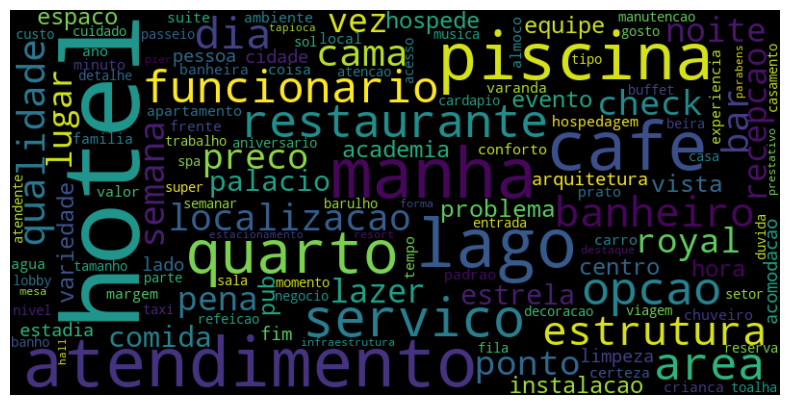

In [21]:
wordcloud_text = ' '.join(df["comments_topic"].astype(str))

wordcloud = WordCloud(width=800, height=400, random_state=15, max_font_size=110, max_words=130, collocations=False).generate(wordcloud_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [22]:
df_comments = df["comments_topic"]
doc_comments = df_comments.to_list()
doc_comments[:5]

['quarto cafe manha predio arquitetura piscina localizacao lado palacio royal opcao restricao sabado hospede drink bar estilo pub',
 'royal estadia check costume restaurante sabar acompanhamento batida royal semana',
 'vez hotel estrutura problema chuva cafe manha hotel vez recepcao relacao estadia hotel decepcao problema hotel opcao carro estacionamento check carro hotel mala carro manobrista cagada brincadeira funcionario hotel nivel forma porta gerente carro porta amarelo situacao tipo servico atencao cuidado gerente sivanildo caso gerente dia dia dia ligacao sivanildo situacao carro secretario gerente area contato dia terca mensagem empresa empresa servico processo acordo empresa avaliacao hotel decepcao relacao hotel desculpa contato despreparo tipo situacao forma hotel resolucao problema situacao padrao hotel carro cisto erro duvida hospedagem carro mao nota atendimento fato atendimento hotel',
 'estadia diaria aniversario casamento reserva hotel transtorno piscina lago pena tama

In [37]:
%%time

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', low_memory=False)
hdbscan_model = HDBSCAN(min_samples=15, min_cluster_size=120, metric='euclidean', prediction_data=True)
topic_model = BERTopic(language="portuguese", calculate_probabilities=True, verbose=True, nr_topics="auto", top_n_words=10, min_topic_size=100, umap_model=umap_model, hdbscan_model=hdbscan_model)
topics, probs = topic_model.fit_transform(doc_comments)

2024-04-15 15:00:40,276 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/65 [00:00<?, ?it/s]

2024-04-15 15:01:28,139 - BERTopic - Embedding - Completed ✓
2024-04-15 15:01:28,140 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-15 15:01:42,706 - BERTopic - Dimensionality - Completed ✓
2024-04-15 15:01:42,706 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-15 15:01:42,968 - BERTopic - Cluster - Completed ✓
2024-04-15 15:01:42,968 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-15 15:01:43,067 - BERTopic - Representation - Completed ✓
2024-04-15 15:01:43,067 - BERTopic - Topic reduction - Reducing number of topics
2024-04-15 15:01:43,169 - BERTopic - Topic reduction - Reduced number of topics from 6 to 6


CPU times: total: 4min 18s
Wall time: 1min 3s


In [38]:
freq = topic_model.get_topic_info(); freq.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,594,-1_hotel_atendimento_lago_manha,"[hotel, atendimento, lago, manha, cafe, quarto...",[hotel lado palacio palacio margem lago arquit...
1,0,424,0_piscina_hotel_lago_manha,"[piscina, hotel, lago, manha, cafe, quarto, at...",[opcao cafe qualidade hotel funcionario restau...
2,1,369,1_hotel_cafe_manha_atendimento,"[hotel, cafe, manha, atendimento, restaurante,...","[valor hotel atendimento cafe manha opcao dia,..."
3,2,239,2_lago_hotel_manha_cafe,"[lago, hotel, manha, cafe, atendimento, quarto...",[hotel instalacao atendimento cafe manha quart...
4,3,232,3_hotel_atendimento_localizacao_funcionario,"[hotel, atendimento, localizacao, funcionario,...",[noite hotel experiencia hotel atendimento man...
5,4,217,4_banheiro_hotel_manha_cafe,"[banheiro, hotel, manha, cafe, piscina, lago, ...",[estrutura quarto banheiro hotel funcionario c...


In [97]:
topic_model.get_topic(4)

[('conforto', 0.2629453744160852),
 ('massagem', 0.13527064601357286),
 ('atendimento', 0.09233520364804439),
 ('hotel', 0.0911875878218706),
 ('spa', 0.07295787060329804),
 ('restaurante', 0.06681768722776613),
 ('qualidade', 0.05630547085883678),
 ('servico', 0.046217506510984885),
 ('manha', 0.04568128836777471),
 ('cafe', 0.0439654236340466)]

In [39]:
topic_model.visualize_barchart(top_n_topics=10)

In [74]:
df_topics = topic_model.get_document_info(doc_comments)
df_info = df.copy()
df_info = df_info.drop(columns=['comments_topic'], axis=1, inplace=False)
df_info["topic"] = df_topics["Topic"]

In [75]:
df_info.head()

,comments,comments_entity,topic
0,Uma vez a cada dois meses eu e meu marido vamo...,uma vez a cada dois meses eu e meu marido vamo...,1
1,Hotel de excelente qualidade. Quarto amplo e m...,hotel de excelente qualidade. quarto amplo e m...,2
2,"Um Hotel elegante, charmoso, aconchegante, com...","um hotel elegante, charmoso, aconchegante, com...",3
3,Ótima opção para um brunch de domingo à tarde....,otima opcao para um brunch de domingo a tarde....,0
4,Muito obrigado pela atenção dispensada e fique...,muito obrigado pela atencao dispensada e fique...,-1


In [76]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
class_names = ['negative', 'neutral', 'positive']

class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [77]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin', map_location ='cpu'))
model = model.to(torch.device('cpu'))

In [78]:
MAX_LEN = 175
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

def predict_sentiment(text):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to("cpu")
    attention_mask = encoded_review['attention_mask'].to("cpu")

    with torch.no_grad():
        output = model(input_ids, attention_mask)

    _, prediction = torch.max(output, dim=1)
    
    return class_names[prediction]

Demorou 15 minutos.

In [79]:
df_info["sentiment"] = df_info["comments"].apply(predict_sentiment)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [80]:
sentiment_counts = df_info.groupby(['topic', 'sentiment']).size().reset_index(name='count')

In [81]:
sentiment_counts

,topic,sentiment,count
0,-1,negative,24
1,-1,neutral,23
2,-1,positive,536
3,0,negative,39
4,0,neutral,40
5,0,positive,805
6,1,negative,20
7,1,neutral,22
8,1,positive,528
9,2,negative,7


In [100]:
sentiment_counts_filt = sentiment_counts.loc[sentiment_counts['topic'] == 4]
sentiment_counts_filt

,topic,sentiment,count
15,4,positive,83


In [82]:
MAX_LEN = 175
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

tokenizer_ner = AutoTokenizer.from_pretrained("51la5/roberta-large-NER", model_max_length=512)
model_ner = XLMRobertaForTokenClassification.from_pretrained("51la5/roberta-large-NER")
ner_task = pipeline("ner", model=model_ner, tokenizer=tokenizer_ner)

Some weights of the model checkpoint at 51la5/roberta-large-NER were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [83]:
def extract_entities(df):
    all_entities = []

    for comment in df["comments_entity"]:
        predictions = ner_task(comment)
        comment_entities = []

        if predictions != []:
            combined_word = ""
            previous_entity = None

            for prediction in predictions:
                entity = prediction['entity']
                word = prediction['word']

                if not word.startswith('▁'):
                    combined_word += word
                else:
                    if combined_word:
                        comment_entities.append((combined_word, previous_entity))
                    combined_word = word

                previous_entity = entity

            if combined_word:
                comment_entities.append((combined_word, previous_entity))

        all_entities.append(comment_entities)

    df_copy = df.copy()
    df_copy["entity"] = all_entities

    return df_copy

In [84]:
df_ner = df_info.copy()
df_ner["entity"] = ""

Demorou 1 hora.

In [85]:
df_ner = extract_entities(df_ner)

In [86]:
count_unique = df_ner['entity'].explode().value_counts()
count_unique

entity
(▁sao, I-LOC)         605
(▁paulo, I-LOC)       587
(▁sp, I-LOC)          169
(▁grand, I-ORG)       163
(▁hyatt, I-ORG)       150
                     ... 
(▁mariane, I-PER)       1
(▁sou, I-PER)           1
(▁veronica, I-PER)      1
(▁rabello, I-PER)       1
(▁nano, I-MISC)         1
Name: count, Length: 512, dtype: int64

In [87]:
count_unique.to_csv("entity_hyatt.txt")

In [122]:
def most_frequent_entity_per_topic(df):
    entity_per_topic = {'topic': [], 'entity_most_frequent': [], 'frequency_entity': []}

    groups = df.groupby('topic')

    for group_name, group_data in groups:
        entity_count = {}

        for index, row in group_data.iterrows():
            for entity_token in row['entity']:
                entity = entity_token[0]
                entity_count[entity] = entity_count.get(entity, 0) + 1

        most_frequent_entities = sorted(entity_count, key=entity_count.get, reverse=True)[:50]
        frequencies = [entity_count[entity] for entity in most_frequent_entities]

        entities_string = ', '.join(most_frequent_entities)
        frequencies_string = ', '.join(map(str, frequencies))

        entity_per_topic['topic'].append(group_name)
        entity_per_topic['entity_most_frequent'].append(entities_string)
        entity_per_topic['frequency_entity'].append(frequencies_string)

    df_most_frequent_entity = pd.DataFrame(entity_per_topic)

    return df_most_frequent_entity


In [139]:
df_entity_most_frequent['entity_most_frequent'] = df_entity_most_frequent['entity_most_frequent'].str.replace('▁', '')

In [140]:
df_entity_most_frequent = most_frequent_entity_per_topic(df_ner)
df_entity_most_frequent.head(10)

,topic,entity_most_frequent,frequency_entity
0,-1,"▁sao, ▁paulo, ▁sp, ▁grand, ▁hyatt, ▁morumbi, ▁...","119, 118, 46, 33, 31, 23, 18, 10, 9, 9, 8, 8, ..."
1,0,"▁sao, ▁paulo, ▁grand, ▁sp, ▁hyatt, ▁morumbi, ▁...","220, 210, 61, 50, 48, 38, 32, 24, 23, 16, 10, ..."
2,1,"▁sao, ▁paulo, ▁hyatt, ▁sp, ▁grand, ▁morumbi, ▁...","138, 134, 42, 37, 30, 24, 13, 12, 11, 7, 4, 4,..."
3,2,"▁sao, ▁paulo, ▁grand, ▁sp, ▁morumbi, ▁hyatt, ▁...","66, 66, 24, 20, 16, 15, 14, 7, 5, 5, 5, 4, 4, ..."
4,3,"▁sao, ▁paulo, ▁sp, ▁morumbi, ▁hyatt, ▁japon, ▁...","38, 35, 11, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 2, 2..."
5,4,"▁sao, ▁paulo, ▁grand, ▁hyatt, ▁sp, ▁hy, umbi, ...","25, 25, 9, 6, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1"


In [138]:
print(df_entity_most_frequent[['entity_most_frequent']].to_string(index=False))

                                                                                                                                                                                                                                                 entity_most_frequent
          ▁sao, ▁paulo, ▁sp, ▁grand, ▁hyatt, ▁morumbi, ▁congonhas, ▁pinheiros, ▁hy, ▁japon, ▁paulista, ▁brasil, ▁globo, ▁marginal, ▁rede, att, ▁guarulhos, ▁eua, ▁transamerica, ▁franc, ▁abe, ▁santo, ▁u2, ada, ▁patricia, ▁clau, ▁castro, ▁namorado, ▁gran, ▁granado
      ▁sao, ▁paulo, ▁grand, ▁sp, ▁hyatt, ▁morumbi, ▁hy, ▁japon, ▁brasil, ▁pinheiros, ▁paulista, ▁globo, ▁congonhas, ▁marginal, ▁japonesa, ▁namorado, ▁rede, ▁de, ▁dos, ▁mundo, ▁guilherme, ▁abe, ▁franc, ▁patricia, ▁place, ▁pauloni, att, ▁itaim, ▁cidade, ▁iguatemi
▁sao, ▁paulo, ▁hyatt, ▁sp, ▁grand, ▁morumbi, ▁hy, ▁paulista, ▁brasil, ▁pinheiros, ▁eua, ▁gran, ▁globo, att, ▁de, ▁londres, ▁ny, ▁americano, ▁itaim, ▁europa, ▁frias, ▁oliveira, ▁jardins, ▁lynphoma, ▁interchange, ▁ja

In [127]:
print(df_entity_most_frequent[['frequency_entity']].to_string(index=False)) 

                                                                                     frequency_entity
   119, 118, 46, 33, 31, 23, 18, 10, 9, 9, 8, 8, 7, 5, 5, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2
220, 210, 61, 50, 48, 38, 32, 24, 23, 16, 10, 8, 7, 6, 6, 6, 6, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3
  138, 134, 42, 37, 30, 24, 13, 12, 11, 7, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1
      66, 66, 24, 20, 16, 15, 14, 7, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1
          38, 35, 11, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1
                                                     25, 25, 9, 6, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1


In [90]:
def show_reviews_by_sentiment_and_topic(df, topic):
    df_topic = df[df['topic'] == topic]

    for sentiment in ['positive', 'neutral', 'negative']:
        print(f"Reviews with sentiment '{sentiment}' in topic '{topic}':")
        
        df_sentiment = df_topic[df_topic['sentiment'] == sentiment]
        
        for i, review_text in enumerate(df_sentiment['comments'].head(5)):
            print(f"{i}. {review_text}")
        print()

In [91]:
df_ner

,comments,comments_entity,topic,sentiment,entity
0,Uma vez a cada dois meses eu e meu marido vamo...,uma vez a cada dois meses eu e meu marido vamo...,1,neutral,"[(▁sp, I-LOC)]"
1,Hotel de excelente qualidade. Quarto amplo e m...,hotel de excelente qualidade. quarto amplo e m...,2,positive,[]
2,"Um Hotel elegante, charmoso, aconchegante, com...","um hotel elegante, charmoso, aconchegante, com...",3,positive,[]
3,Ótima opção para um brunch de domingo à tarde....,otima opcao para um brunch de domingo a tarde....,0,positive,[]
4,Muito obrigado pela atenção dispensada e fique...,muito obrigado pela atencao dispensada e fique...,-1,positive,[]
...,...,...,...,...,...
2618,Este moderno hotel é uma escolha excelente que...,este moderno hotel e uma escolha excelente que...,3,positive,"[(▁de, I-LOC), (▁santosrio, I-LOC)]"
2619,"uma elegância contemporânea, um excelente serv...","uma elegancia contemporanea, um excelente serv...",1,positive,"[(▁morumbi, I-LOC), (▁sao, I-LOC), (▁paulo, I-..."
2620,Muito bom hotel tanto para executivos ou turis...,muito bom hotel tanto para executivos ou turis...,0,positive,"[(▁japon, I-MISC)]"
2621,I se hospedaram no Grand Hyatt para em algumas...,i se hospedaram no grand hyatt para em algumas...,0,neutral,"[(▁sao, I-LOC), (▁paulo, I-LOC)]"


In [105]:
show_reviews_by_sentiment_and_topic(df_ner, 4)

Reviews with sentiment 'positive' in topic '4':
0. Serviço excelente, localização perfeita e ótimo preço. Funcionários muito atenciosos e educados. Quarto com muito conforto e extremamente silencioso. O Hyatt proporciona uma estadia de alta qualidade e custo baixo sendo assim a melhor escolha de hospedagem.
1. excelente hotel, com uma infraestrutura excelente e que oferece ao hospede todo conforto do hall ate os quartos. Tem uma academia bastante estruturada e completa . Voce pode ter a comodidade de visitar centros comerciais proximos
2. Foi uma experiência unica em termos de qualidade conforto e excelente atendimento, pois sempre tinha alguém para auxiliar em tudo que fosso preciso, não igual a todas as outras hospedagem em que fiquei, pois no Grand Hyatt São Paulo, ninguém fingia que não estava te vendo ou ficava escondido atras de um tela de computador fingindo estar ocupado, todos os atendimentos foi com um sorriso no rosto por parte dos funcionários, fora a presteza e a agilidade